In [1]:
import tensorflow as tf
print("Versión de tensorflow:{}".format(tf.__version__))
print("GPU:{}".format(tf.test.gpu_device_name()))

Versión de tensorflow:2.3.0
GPU:/device:GPU:0


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from tensorflow.keras.applications import ResNet50V2
#from tensorflow import keras
#from tensorflow.keras import layers

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
import os 
os.listdir('.')

['.ipynb_checkpoints',
 'cassava-disease',
 'Cassava_best_modelP8.h5',
 'Cassava_best_modelR.h5',
 'Cassava_best_modelR2.h5',
 'FineTuningP8.ipynb',
 'FineTuningResNet.ipynb',
 'FineTuningResNet2.ipynb',
 'FineTuningVGG16.ipynb',
 'foo.png',
 'Primera Base Xception.ipynb',
 'PRIMERA COMPETENCIA',
 'PrimeraBaseXception.h5',
 'Segunda Base ResNet50.ipynb',
 'Segunda Base Xception.ipynb',
 'SEGUNDA COMPETENCIA',
 'SegundaBaseResNet50.h5',
 'SegundaBaseXception.h5',
 'test 2']

In [6]:
# Verificación de lo que hay en la carpeta Kaggle
PATH = 'cassava-disease'

os.listdir(PATH)

['CONFUNDIDAS',
 'Confundidas por el modelo',
 'test',
 'test 2',
 'trainCompletaMod3',
 'trainCompletaMod4',
 'trainCompletaMod5.1',
 'Validacion1',
 'Validacion2']

In [7]:
base_dir = os.path.join(os.path.dirname(PATH), 'cassava-disease')
train_dir = os.path.join(base_dir, 'trainCompletaMod5.1')
test_dir = os.path.join(base_dir, 'test 2')

train_cbb_dir = os.path.join(train_dir, 'cbb')  # directory with our training cat pictures
train_cbsd_dir = os.path.join(train_dir, 'cbsd')  # directory with our training dog pictures
train_cgm_dir = os.path.join(train_dir, 'cgm')  # directory with our training dog pictures
train_cmd_dir = os.path.join(train_dir, 'cmd')  # directory with our training dog pictures
train_healthy_dir = os.path.join(train_dir, 'healthy')  # directory with our training dog pictures
#validation_0_dir = os.path.join(validation_dir, '0')  # directory with our validation cat pictures

In [8]:
num_cbb_tr = len(os.listdir(train_cbb_dir))
num_cbsd_tr = len(os.listdir(train_cbsd_dir))
num_cgm_tr = len(os.listdir(train_cgm_dir))
num_cmd_tr = len(os.listdir(train_cmd_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))

#num_0_val = len(os.listdir(validation_0_dir))

total_train = num_cbb_tr + num_cbsd_tr + num_cgm_tr + num_cmd_tr + num_healthy_tr
#total_val = num_0_val 

In [10]:
print('total training cbb images:', num_cbb_tr)
print('total training cbsd images:', num_cbsd_tr)
print('total training cgm images:', num_cgm_tr)
print('total training cmd images:', num_cmd_tr)
print('total training healthy images:', num_healthy_tr)

#print('total validation 0 images:', num_0_val)
print("--")
print("Total training images:", total_train)
#print("Total validation images:", total_val)

total training cbb images: 1224
total training cbsd images: 1224
total training cgm images: 1224
total training cmd images: 1224
total training healthy images: 1224
--
Total training images: 6120


In [11]:
BATCH_SIZE = 8  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 512  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [12]:
train_image_generator      = ImageDataGenerator(rescale=1./255,
                                               validation_split=0.1022,
                                               rotation_range = 45,
                                               zoom_range = 0.2,
                                               vertical_flip=True,
                                               horizontal_flip=True,
                                               fill_mode = 'nearest',
                                               shear_range = 0.1,
                                               height_shift_range = 0.1,
                                               width_shift_range = 0.1)  # Generator for our training data
#validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,                                                    
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='sparse',
                                                           subset='training')

Found 5495 images belonging to 5 classes.


In [14]:
NUM_TRAINING_IMAGES=5495

In [15]:
val_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=train_dir,                                                              
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='sparse',
                                                              subset='validation')

Found 625 images belonging to 5 classes.


In [16]:
NUM_VALIDATION_IMAGES=625

In [17]:
sample_training_images, _ = next(train_data_gen) 

In [18]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

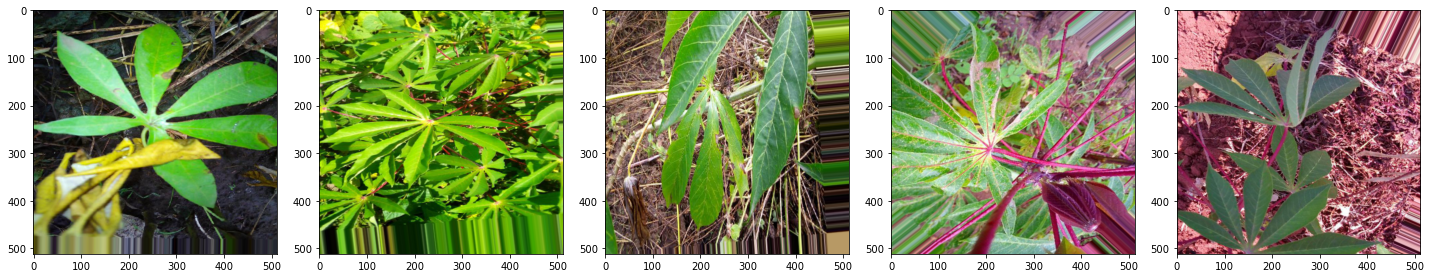

In [19]:
plotImages(sample_training_images[:5])  # Plot images 0-4

In [20]:
model1 = tf.keras.applications.VGG16(weights='imagenet')

In [21]:
model1.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(IMG_SHAPE, IMG_SHAPE, 3), include_top=False, weights="imagenet")

In [24]:
for layer in pre_trained_model.layers[:]:
   layer.trainable = False

print('conv_base is now NOT trainable')

conv_base is now NOT trainable


In [43]:
from tensorflow.keras import backend as K


In [44]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_4
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [25]:
# PARA SABER QUE CAPAS SE ESTAN ENTRENANDO
for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [26]:
last_layer = pre_trained_model.get_layer('block5_conv1')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 32, 32, 512)


# Modelo

In [27]:
model = tf.keras.Sequential([
        pre_trained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
        tf.keras.layers.Dense(512, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 15,767,365
Trainable params: 1,052,677
Non-trainable params: 14,714,688
____________________________________

In [29]:
# PARA SABER QUE CAPAS SE ESTAN ENTRENANDO
for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [30]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [31]:
EPOCHS = 20
history = model.fit(
    train_data_gen, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_data_gen,
    validation_steps=VALID_STEPS)#class_weight=class_weight2

Epoch 1/20
686/686 [==============================] - 455s 663ms/step - loss: 2.1163 - acc: 0.4124 - val_loss: 1.3504 - val_acc: 0.5032
Epoch 2/20
686/686 [==============================] - 376s 548ms/step - loss: 1.3524 - acc: 0.4735 - val_loss: 1.5537 - val_acc: 0.3574
Epoch 3/20
686/686 [==============================] - 378s 552ms/step - loss: 1.2965 - acc: 0.4882 - val_loss: 1.3319 - val_acc: 0.5048
Epoch 4/20
686/686 [==============================] - 380s 554ms/step - loss: 1.2545 - acc: 0.5170 - val_loss: 1.2868 - val_acc: 0.5256
Epoch 5/20
686/686 [==============================] - 379s 552ms/step - loss: 1.2194 - acc: 0.5378 - val_loss: 1.2157 - val_acc: 0.5673
Epoch 6/20
686/686 [==============================] - 380s 554ms/step - loss: 1.1842 - acc: 0.5617 - val_loss: 1.1921 - val_acc: 0.5913
Epoch 7/20
686/686 [==============================] - 378s 551ms/step - loss: 1.1441 - acc: 0.5859 - val_loss: 1.1389 - val_acc: 0.5849
Epoch 8/20
686/686 [============================

### FINE TUNING

In [33]:
pre_trained_model.layers[15].name

'block5_conv1'

In [34]:
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 15,767,365
Trainable params: 8,132,101
Non-trainable params: 7,635,264
_____________________________________

In [36]:
# PARA SABER QUE CAPAS SE ESTAN ENTRENANDO
for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [37]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])

In [38]:
# Save the model with the minimum validation loss
checkpoint_cb = ModelCheckpoint("Cassava_best_modelVGG16.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
#early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           #patience = 5, mode = 'min', verbose = 1,
                           #restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [39]:
EPOCHS = 20
history = model.fit(
    train_data_gen, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_data_gen,
    validation_steps=VALID_STEPS,
    callbacks = [checkpoint_cb, reduce_lr])#class_weight=class_weight2

Epoch 1/20
686/686 [==============================] - 438s 638ms/step - loss: 0.9044 - acc: 0.7130 - val_loss: 0.8595 - val_acc: 0.7468
Epoch 2/20
686/686 [==============================] - 414s 603ms/step - loss: 0.7987 - acc: 0.7576 - val_loss: 0.7450 - val_acc: 0.7965
Epoch 3/20
686/686 [==============================] - 414s 603ms/step - loss: 0.7358 - acc: 0.7787 - val_loss: 0.7337 - val_acc: 0.7869
Epoch 4/20
686/686 [==============================] - 413s 603ms/step - loss: 0.6715 - acc: 0.8065 - val_loss: 0.7421 - val_acc: 0.7788
Epoch 5/20
686/686 [==============================] - 414s 603ms/step - loss: 0.6380 - acc: 0.8194 - val_loss: 0.6417 - val_acc: 0.8221
Epoch 6/20
686/686 [==============================] - 414s 604ms/step - loss: 0.5984 - acc: 0.8334 - val_loss: 0.6203 - val_acc: 0.8397
Epoch 7/20
686/686 [==============================] - 414s 604ms/step - loss: 0.5755 - acc: 0.8369 - val_loss: 0.5526 - val_acc: 0.8718
Epoch 8/20
686/686 [============================

In [40]:
from tensorflow import keras
final_model = keras.models.load_model('Cassava_best_modelVGG16.h5')


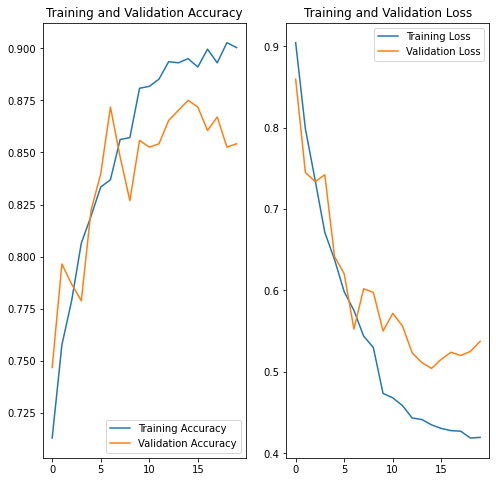

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [42]:
test_image_generator = ImageDataGenerator(rescale = 1./255)

In [43]:
import random
seed = random.randint(1, 1000)
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_dir,                                                    
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='sparse')  

Found 625 images belonging to 5 classes.


In [44]:
NUM_TEST_IMAGES = 625
TEST_STEPS = NUM_TEST_IMAGES // BATCH_SIZE

In [45]:
# Evaluate the performance of the model
from tensorflow.keras.models import Model, load_model
model.load_weights("Cassava_best_modelVGG16.h5")
evaluate = model.evaluate(test_data_gen, steps = TEST_STEPS, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

78/78 [==============================] - 37s 468ms/step - loss: 0.5046 - acc: 0.8718
Accuracy Test : 0.8717948794364929


              precision    recall  f1-score   support

           0     0.9048    0.9120    0.9084       125
           1     0.9417    0.9040    0.9224       125
           2     0.9828    0.9120    0.9461       125
           3     0.9512    0.9360    0.9435       125
           4     0.8786    0.9840    0.9283       125

    accuracy                         0.9296       625
   macro avg     0.9318    0.9296    0.9297       625
weighted avg     0.9318    0.9296    0.9297       625



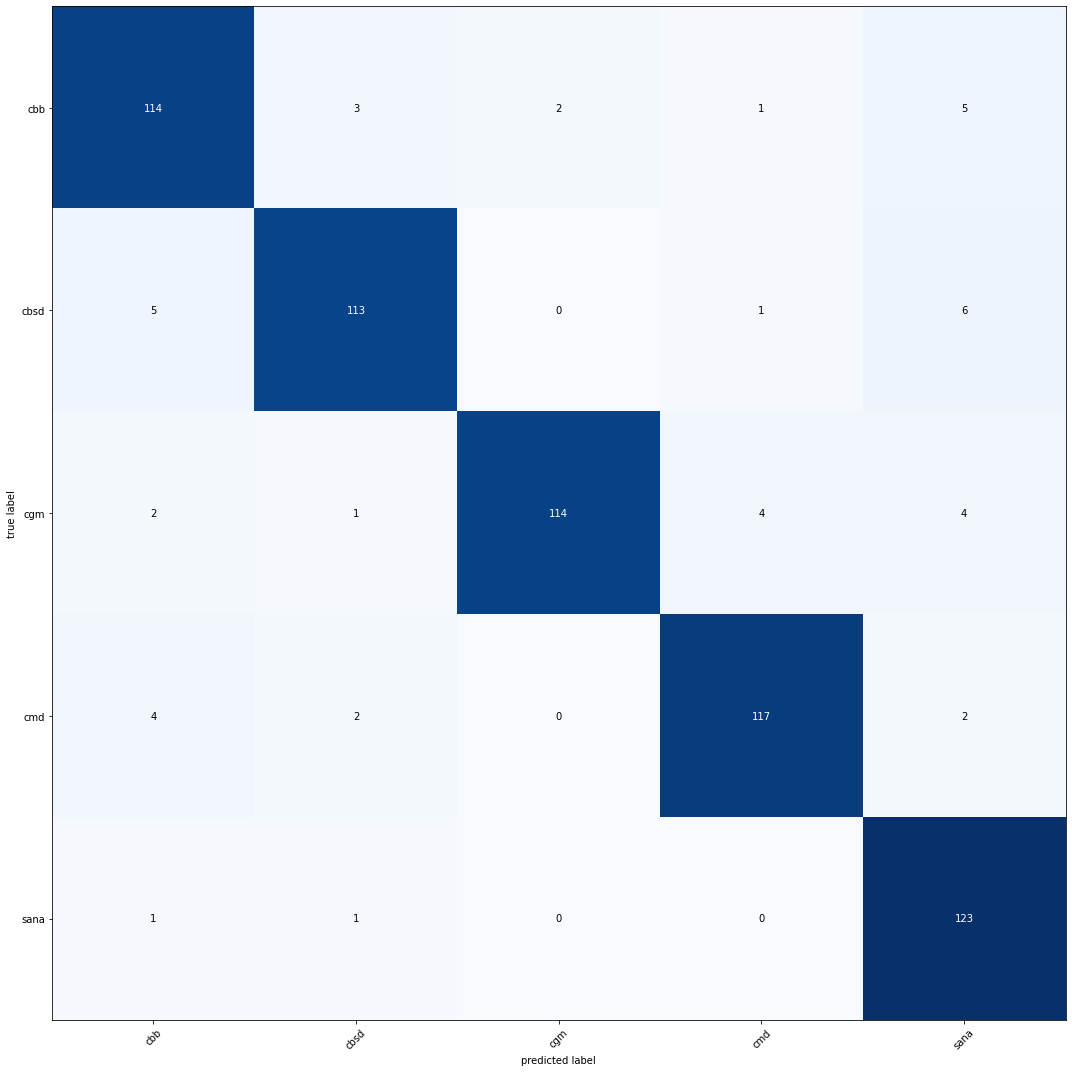

In [65]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

names = ['cbb','cbsd','cgm','cmd','sana']

custom_Model= keras.models.load_model('Cassava_best_modelVGG16.h5')
#modelt = custom_model

predictions = custom_Model.predict_generator(generator=test_data_gen)

y_pred = np.argmax(predictions, axis=1)
y_real = test_data_gen.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(15,15), class_names = names, show_normed=False)
plt.tight_layout()
print(metrics.classification_report(y_real,y_pred, digits = 4))

In [ ]:
#val_data_dir = 'C:/Users/bendf/Documents/Prueba/'  
#test_images = os.listdir(val_data_dir)
IMG_SHAPE=512
validation_dir = os.path.join(base_dir, 'Validacion2')
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(batch_size=20,
                                                directory= validation_dir,
                                                target_size=(IMG_SHAPE, IMG_SHAPE), 
                                                class_mode='categorical', 
                                                shuffle=True)

In [ ]:
val_images=next(val_generator)[0]
val_images

In [ ]:
classes = final_model.predict(val_images)  #y_pred
y_pred = np.argmax(classes, axis=1)
classes

In [ ]:
import skimage

In [ ]:
# Mostramos las 20 imágenes del batch y las etiquetas asignadas por MobileNet.
plot_n_images = 10
fig = plt.figure(figsize=(20, 17))

for i in range(0,5):
    for j in range(0,4):
        counter = i*4+j
        fig_i=fig.add_subplot(4,5,counter+1)
        fig_i.imshow(val_images[counter])
        
        fig_i.set_xticks(())
        fig_i.set_yticks(())
        
        fig_i.set_xlabel('%s'%y_pred[counter])
        

In [ ]:
test_data_dir = 'C:/Users/bendf/Documents/Prueba/'  
test_images = os.listdir(test_data_dir)
validation_dir = os.path.join(base_dir, 'Prueba')
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE), 
    batch_size = 2,
    class_mode='categorical', 
    shuffle=False)

In [ ]:
next(test_generator)[0]

In [ ]:
from tensorflow import keras
from keras.models import load_model
saved_model = load_model('Cassava_best_model.h5')

In [ ]:
from tensorflow import keras
from PIL import Image
image = tf.keras.preprocessing.image.load_img(f'{PATH}/Prueba/')

In [ ]:
validation_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train_images')

In [ ]:
import numpy as np
from tf.keras.preprocessing import image

img = tf.keras.preprocessing.image.load_img(Predict_dir, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(fn)
print(classes)

In [ ]:
encoder = ResNet50V2(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet'
)
encoder.trainable = False

inputs = keras.Input(shape=IMG_SHAPE)
#x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = encoder(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) 
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()